### 1. Установка необходимых пакетов / загрузка библиотек

In [1]:
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from catboost import CatBoostClassifier as catb

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### 2. Подготовка функций для работы с данными

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print("TRAIN:", round(f1_score(y_train, y_train_pred), 3))
    print("TEST:", round(f1_score(y_valid, y_valid_pred), 3))
    print('=' * 20)
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (8, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### 3. Загрузка данных

In [8]:
# Input:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

# Output:
SAMPLE_SUBMIT_PATH = './BBurtsev_predictions.csv'

# Usefull vars:
TARGET_NAME = 'Credit Default'
RANDOM_STATE = 42

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### 4. Классы для обработки данных и создания новых признаков

In [10]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.modes = None
        self.purpose_dict = {
            'debt consolidation': 0,
            'other': 1,
            'home improvements': 1,
            'business loan': 2,
            'buy a car': 1,
            'medical bills': 1,
            'major purchase': 1,
            'take a trip': 1,
            'buy house': 1,
            'small business': 2,
            'wedding': 1,
            'moving': 1,
            'educational expenses': 1,
            'vacation': 1,
            'renewable energy': 1
        }
        self.home_ownership_dict = {
            'Own Home': 0,
            'Rent': 1,
            'Home Mortgage': 2
        }
        self.term_dict = {
            'Short Term': 0,
            'Long Term': 1
        }
        self.crn_job_years_dict = {
            '10+ years':10, 
            '8 years':8, 
            '6 years':6, 
            '7 years':7, 
            '5 years':5, 
            '1 year':1,
            '< 1 year':0, 
            '4 years':4, 
            '3 years':3, 
            '2 years':2, 
            '9 years':9
        }
      
    @staticmethod
    def find_upper_boundary(col):
        q3 = col.quantile(0.75)
        iqr = q3 - col.quantile(0.25)
        upper_bound = q3 + 3 * iqr
        return upper_bound
        
    @staticmethod
    def create_mask(X, f_name):
        q3 = X[f_name].quantile(0.75)
        iqr = q3 - X[f_name].quantile(0.25)
        upper_bound = q3 + 3 * iqr        
        mask = X[f_name] > upper_bound
        return mask
        
    def fit(self, X):
        """сохранение статистик"""
        X = X.copy()
        self.medians = X.median()
        self.modes = X.mode().loc[0]
        
    def transform(self, X):
        """трансформация данных"""
        
        # Home Ownership
        feature_name = 'Home Ownership'
        X.loc[X[feature_name] == 'Have Mortgage', feature_name] = 'Home Mortgage'
        X.replace({feature_name: self.home_ownership_dict}, inplace=True)
        
        # Term
        feature_name = 'Term'
        X.replace({feature_name: self.term_dict}, inplace=True)
        
        # Purpose
        feature_name = 'Purpose'
        X.replace({feature_name: self.purpose_dict}, inplace=True)
        
        # === 1.ВЫБРОСЫ ===
        # Annual Income
        feature_name = 'Annual Income'
        mask = self.create_mask(X, feature_name)
        X.loc[mask, feature_name] = self.medians[feature_name]
        
        # Number of open accounts
        feature_name = 'Number of Open Accounts'
        mask = self.create_mask(X, feature_name)  
        X.loc[mask, feature_name] = self.medians[feature_name]
        
        # Current Loan Amount
        feature_name = 'Current Loan Amount'
        mask = self.create_mask(X, feature_name)
        X.loc[mask, feature_name] = self.medians[feature_name]
        
        # Maximum Open Credit
        feature_name = 'Maximum Open Credit'
        max_credit = X[feature_name].max()
        mask = X[feature_name] > max_credit
        X.loc[mask, feature_name] = self.medians[feature_name]
        
        # Credit Score
        feature_name = 'Credit Score'
        score_mask = X[feature_name] > 1500
        mask = (X[feature_name] > 1500) & (X[feature_name] % 10 == 0)
        X.loc[mask, 'Credit Score'] = X.loc[score_mask, feature_name] / 10
        
        # === 2.ПРОПУСКИ ===
        
        # Annual Income
        X['Annual Income'].fillna(X['Annual Income'].median(), inplace = True)
        
        # Years in current job
        feature_name = 'Years in current job'
        X[feature_name].fillna(self.modes[feature_name], inplace = True)
        X.replace({feature_name: self.crn_job_years_dict}, inplace=True)
        
        # Months since last delinquent
        feature_name = 'Months since last delinquent'
        X.loc[X[feature_name].isnull(), feature_name] = 0
        
        # Bankruptcies
        feature_name = 'Bankruptcies'        
        not_bankrupt = X[feature_name].isnull() & (X['Number of Credit Problems'] == 0)
        is_bankrupt = X[feature_name].isnull() & (X['Number of Credit Problems'] > 0)

        X.loc[not_bankrupt, feature_name] = 0
        X.loc[is_bankrupt, feature_name] = 1
        
        X.loc[X[feature_name] > 0, feature_name] = 1
        
        # Credit Score
        feature_name = 'Credit Score'  
        X[feature_name].fillna(X[feature_name].median(), inplace = True)
        
        return X

In [11]:
class FeatureGenerator:
    """Генератор новых признаков"""
        
    def transform(self, X):
        # Tax Liens
        X['is_tax_liens'] = np.where(X['Tax Liens'] > 0, 1, 0)
        
        # Number of Credit Problems
        X['is_problem'] = np.where(X['Number of Credit Problems'] > 0, 1, 0)
        
        # Monthly Debt / Annual Income
        X['monthly_debt_to_annual_income'] = X['Monthly Debt'] / X['Annual Income']
        
        return X

### 5. Предобработка данных

In [12]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [13]:
features_gen = FeatureGenerator()

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

### 6. Разбиение на train и test

In [14]:
X = train_df.drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

### 7. Построение модели CatBoost

In [16]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Term', 'Years in current job', 'Purpose', 'is_problem', 'is_tax_liens']

In [17]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.6266924564796907

In [18]:
frozen_params = {
    'class_weights': [1, disbalance], 
    'silent': True,
    'random_state': RANDOM_STATE,
    'eval_metric': 'F1',
#     'early_stopping_rounds': 20,
    'cat_features': CAT_FEATURE_NAMES
}

model = catb(
    **frozen_params,
    use_best_model=True,
    custom_metric=['Precision', 'Recall'],
    iterations=50,
    max_depth=5,
    min_data_in_leaf=5,
)

model.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
evaluate_preds(model, X_train, X_valid, y_train, y_valid)

TRAIN: 0.533
TEST: 0.515
TRAIN

              precision    recall  f1-score   support

           0       0.86      0.62      0.72      4074
           1       0.42      0.73      0.53      1551

    accuracy                           0.65      5625
   macro avg       0.64      0.67      0.63      5625
weighted avg       0.74      0.65      0.67      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.58      0.68      1313
           1       0.41      0.69      0.52       562

    accuracy                           0.61      1875
   macro avg       0.61      0.63      0.60      1875
weighted avg       0.69      0.61      0.63      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               766  547
1               177  385


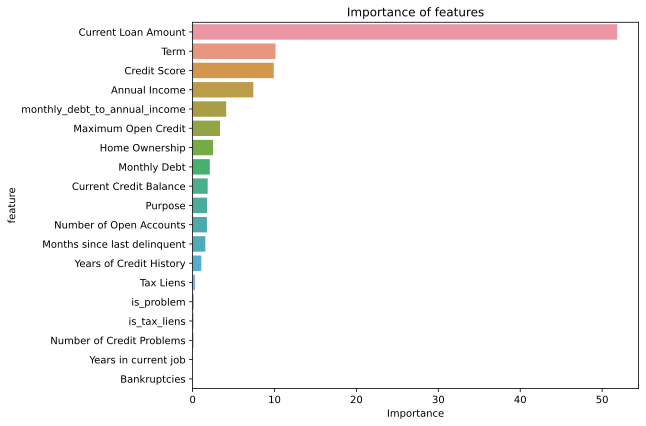

In [20]:
important_features_top = show_feature_importances(X.columns, model.feature_importances_, get_top=15)

In [21]:
important_features_top

['Current Loan Amount',
 'Term',
 'Credit Score',
 'Annual Income',
 'monthly_debt_to_annual_income',
 'Maximum Open Credit',
 'Home Ownership',
 'Monthly Debt',
 'Current Credit Balance',
 'Purpose',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Years of Credit History',
 'Tax Liens',
 'is_problem']

In [22]:
X_train = X_train[important_features_top]
X_valid = X_valid[important_features_top]  
test_df = test_df[important_features_top]

In [23]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['is_problem', 'Home Ownership', 'Purpose', 'Term']

In [24]:
frozen_params = {
    'class_weights': [1, disbalance], 
    'silent': True,
    'random_state': RANDOM_STATE,
    'eval_metric': 'F1',
    'early_stopping_rounds': 20,
    'cat_features': NEW_CAT_FEATURE_NAMES
}

final_model = catb(**frozen_params, iterations=35, max_depth=5, min_data_in_leaf=5)
final_model.fit(X_train[important_features_top], y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
evaluate_preds(final_model, X_train[important_features_top], X_valid[important_features_top], y_train, y_valid)

TRAIN: 0.577
TEST: 0.505
TRAIN

              precision    recall  f1-score   support

           0       0.89      0.64      0.75      4074
           1       0.46      0.79      0.58      1551

    accuracy                           0.68      5625
   macro avg       0.67      0.71      0.66      5625
weighted avg       0.77      0.68      0.70      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      1313
           1       0.41      0.66      0.50       562

    accuracy                           0.61      1875
   macro avg       0.61      0.63      0.59      1875
weighted avg       0.68      0.61      0.63      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               773  540
1               190  372


### 8. Прогнозирование на тестовом датасете

In [26]:
predictions = final_model.predict(test_df)
predictions

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [27]:
submit_df = pd.DataFrame(predictions, columns=['Credit Default'])
submit_df.value_counts()

Credit Default
0                 1375
1                 1125
dtype: int64

In [28]:
submit_df.to_csv(SAMPLE_SUBMIT_PATH, index=False)